In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install torch==1.5.0  torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 29kB/s 
     |████████████████████████████████| 6.5MB 30.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision
from torchsummary import summary
from myfunctions import *
from models import *
from Grad_Cam import get_last_conv,Grad_Cam
from transforms_dataloading import downloading_data_transforms_albumentations
from tqdm import tqdm

from albumentations import  ( 
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose , Normalize ,ToFloat, Cutout
)

import cv2

import numpy as np

# from albumentations.pytorch import  ToTensor 

In [ ]:
print(torch. __version__)
print(torchvision. __version__)

1.5.0+cu92
0.6.0+cu92


In [ ]:
dataset_dir="/content/drive/My Drive/Colab Notebooks/EVA_P2/S6/CARS"

**Downloading datasets and applying transforms**

In [ ]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


**Loading data to train and test loader**

In [ ]:
CROP_SIZE = 64
UPSCALE_FACTOR=4
NUM_EPOCHS=50

In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/EVA_P2/S8"

/content/drive/My Drive/Colab Notebooks/EVA_P2/S8


In [ ]:
from model import *
from loss import *
from utils import *
from ssim import *

In [ ]:

train_set = TrainDatasetFromFolder(dataset_dir, crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set = ValDatasetFromFolder(dataset_dir, upscale_factor=UPSCALE_FACTOR)

In [ ]:

train_loader = torch.utils.data.DataLoader(dataset=train_set, num_workers=4, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)


In [ ]:
import argparse
import os
from math import log10

import pandas as pd
import torch.optim as optim
import torch.utils.data
import torchvision.utils as utils
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm


# from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
# from loss import GeneratorLoss
# from model import Generator, Discriminator

netG = Generator(UPSCALE_FACTOR)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

generator_criterion = GeneratorLoss()

if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

for epoch in range(1, NUM_EPOCHS + 1):
    print("Epoch.....",epoch)
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}

    netG.train()
    netD.train()
    for data, target in train_bar:
        g_update_first = True
        batch_size = data.size(0)
        running_results['batch_sizes'] += batch_size

        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        
        
        
        optimizerG.step()

        # loss for current batch before optimization 
        running_results['g_loss'] += g_loss.item() * batch_size
        running_results['d_loss'] += d_loss.item() * batch_size
        running_results['d_score'] += real_out.item() * batch_size
        running_results['g_score'] += fake_out.item() * batch_size

        # train_bar.set_description(desc='[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f' % (
        #     epoch, NUM_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        #     running_results['g_loss'] / running_results['batch_sizes'],
        #     running_results['d_score'] / running_results['batch_sizes'],
        #     running_results['g_score'] / running_results['batch_sizes']))

    netG.eval()
    out_path = 'training_results/SRF_' + str(UPSCALE_FACTOR) + '/'
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    with torch.no_grad():
        val_bar = tqdm(val_loader)
        valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
        val_images = []
        for val_lr, val_hr_restore, val_hr in val_bar:
            batch_size = val_lr.size(0)
            valing_results['batch_sizes'] += batch_size
            lr = val_lr
            hr = val_hr
            if torch.cuda.is_available():
                lr = lr.cuda()
                hr = hr.cuda()
            sr = netG(lr)
    
            batch_mse = ((sr - hr) ** 2).data.mean()
            valing_results['mse'] += batch_mse * batch_size
            batch_ssim = ssim(sr,hr).item()
            valing_results['ssims'] += batch_ssim * batch_size
            valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
            valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
            if epoch % 50 == 0:
              val_bar.set_description(
                  desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                      valing_results['psnr'], valing_results['ssim']))
      
            val_images.extend(
                [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                  display_transform()(sr.data.cpu().squeeze(0))])
        val_images = torch.stack(val_images)
        val_images = torch.chunk(val_images, val_images.size(0) // 15)
        if epoch % 50 == 0:
          print("starts hear............")
          val_save_bar = tqdm(val_images, desc='[saving training results]')
        
          index = 1
          for image in val_save_bar:
              image = utils.make_grid(image, nrow=3, padding=5)
              utils.save_image(image, out_path + 'epoch_%d_index_%d.png' % (epoch, index), padding=5)
              index += 1

    # save model parameters
    if epoch % 50 == 0:
      print("oyeeeeeeeeee")
      out_pat = 'training_results/epochs/'
      if not os.path.exists(out_pat):
          os.makedirs(out_pat)
      
      torch.save(netG.state_dict(), 'training_results/epochs/netG_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
      torch.save(netD.state_dict(), 'training_results/epochs/netD_epoch_%d_%d.pth' % (UPSCALE_FACTOR, epoch))
    # save loss\scores\psnr\ssim
      results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
      results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
      results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
      results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
      results['psnr'].append(valing_results['psnr'])
      results['ssim'].append(valing_results['ssim'])

      if epoch % 50 == 0 and epoch != 0:
        out_path = 'training_results/'
        data_frame = pd.DataFrame(
            data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                  'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']},
            index=range(1, epoch + 1))
        data_frame.to_csv(out_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

# generator parameters: 734219
# discriminator parameters: 5215425


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 1


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 2


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 3


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 4


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 5


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 6


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 7


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 8


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 9


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 10


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 11


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 12


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 13


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 14


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 15


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 16


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 17


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 18


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 19


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 20


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 21


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 22


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 23


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 24


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 25


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 26


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 27


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 28


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 29


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 30


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 31


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 32


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 33


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 34


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 35


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 36


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 37


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 38


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 39


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 40


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 41


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 42


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 43


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 44


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 45


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 46


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 47


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 48


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 49


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch..... 50


100%|██████████| 43/43 [00:03<00:00, 11.71it/s]
[converting LR images to SR images] PSNR: 23.6029 dB SSIM: 0.8797: 100%|██████████| 344/344 [00:08<00:00, 40.96it/s]
[saving training results]:   0%|          | 0/65 [00:00<?, ?it/s]

starts hear............


[saving training results]: 100%|██████████| 65/65 [00:41<00:00,  1.57it/s]


oyeeeeeeeeee


In [ ]:
IMAGE_NAME="/content/drive/My Drive/Colab Notebooks/EVA_P2/S8/Image_3_.jpg"


In [ ]:
import argparse
import time

import torch
from PIL import Image
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage

# from model import Generator


TEST_MODE = True 

model = Generator(UPSCALE_FACTOR).eval()
if TEST_MODE:
    model.cuda()
    model.load_state_dict(torch.load("/content/drive/My Drive/Colab Notebooks/EVA_P2/S8/training_results/epochs/netG_epoch_4_50.pth"))


image = Image.open(IMAGE_NAME)
image = Variable(ToTensor()(image), volatile=True).unsqueeze(0)
if TEST_MODE:
    image = image.cuda()

start = time.clock()
out = model(image)
elapsed = (time.clock() - start)
print('cost' + str(elapsed) + 's')
out_img = ToPILImage()(out[0].data.cpu())
out_img.save("/content/drive/My Drive/Colab Notebooks/EVA_P2/S8/training_results/epochs/Img.jpg")

cost0.008494000000041524s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


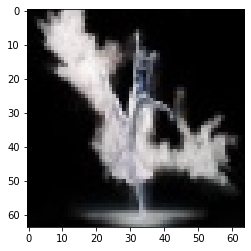

In [ ]:
import  matplotlib.pyplot as plt
import cv2 as cv
imgs = cv.imread("/content/drive/My Drive/Colab Notebooks/EVA_P2/S8/Image_3_.jpg")
plt.imshow(imgs)

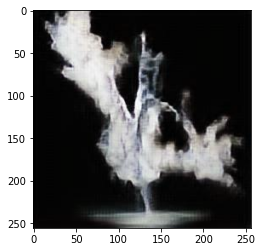

In [ ]:
import  matplotlib.pyplot as plt
import cv2 as cv
img = cv.imread("/content/drive/My Drive/Colab Notebooks/EVA_P2/S8/training_results/epochs/Img.jpg")
plt.imshow(img)